<a href="https://colab.research.google.com/github/hardik-vala/unicorn-namegen/blob/main/unicorn_namegen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
!wget https://raw.githubusercontent.com/hardik-vala/unicorn-namegen/main/names.txt

--2023-03-23 05:39:06--  https://raw.githubusercontent.com/hardik-vala/unicorn-namegen/main/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8257 (8.1K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>]   8.06K  --.-KB/s    in 0.001s  

2023-03-23 05:39:06 (12.6 MB/s) - ‘names.txt’ saved [8257/8257]



In [3]:
names = open('names.txt', 'r').read().splitlines()

In [4]:
len(names)

854

In [5]:
min_name_len = min(len(n) for n in names)
min_name_len

2

In [6]:
max_name_len = max(len(n) for n in names)
max_name_len

34

In [7]:
[n for n in names if len(n) == min_name_len]

['9F', 'G2', 'Ro']

In [8]:
[n for n in names if len(n) == max_name_len]

['LinkSure Network (WiFi Master Key)']

In [9]:
b = {}
for n in names:
  chs = ['<S>'] + list(n) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

In [10]:
sorted(b.items(), key=lambda kv: -kv[1])

[(('e', '<E>'), 119),
 (('s', '<E>'), 89),
 (('a', 'n'), 85),
 (('<S>', 'S'), 77),
 (('i', 'n'), 74),
 (('a', 'r'), 72),
 (('e', 'r'), 72),
 (('r', 'e'), 64),
 (('<S>', 'C'), 63),
 (('o', 'n'), 62),
 (('<S>', 'A'), 60),
 (('y', '<E>'), 59),
 (('o', '<E>'), 58),
 (('a', 'l'), 57),
 (('<S>', 'M'), 57),
 (('o', 'r'), 56),
 (('e', 'n'), 56),
 (('i', 't'), 56),
 (('t', '<E>'), 54),
 (('n', '<E>'), 52),
 (('r', 'a'), 52),
 (('a', '<E>'), 51),
 (('o', 'u'), 51),
 (('r', 'o'), 50),
 (('l', 'i'), 49),
 (('i', 'c'), 48),
 (('l', 'o'), 46),
 (('t', 'i'), 45),
 (('n', 't'), 45),
 (('<S>', 'B'), 45),
 (('<S>', 'D'), 45),
 (('<S>', 'P'), 45),
 (('r', '<E>'), 44),
 (('<S>', 'T'), 43),
 (('n', 'g'), 42),
 (('l', 'a'), 41),
 (('r', 'i'), 40),
 (('o', 'l'), 39),
 (('<S>', 'G'), 39),
 (('t', 'e'), 38),
 (('o', 'm'), 38),
 (('t', 'a'), 37),
 (('e', 't'), 37),
 (('m', '<E>'), 36),
 (('n', 'd'), 35),
 (('i', 'a'), 35),
 (('a', 't'), 35),
 (('e', 'c'), 35),
 (('e', 's'), 34),
 (('c', 'h'), 33),
 (('<S>', 'F'

In [11]:
chars = sorted(list(set(''.join(names))))
stoi = { s: i + 1 for i,s in enumerate(chars) }
stoi['!'] = 0
itos = { i: s for s, i in stoi.items() }

In [12]:
N = torch.zeros((len(stoi), len(stoi)), dtype=torch.int32)

In [13]:
for n in names:
  chs = ['!'] + list(n) + ['!']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

(-0.5, 73.5, 73.5, -0.5)

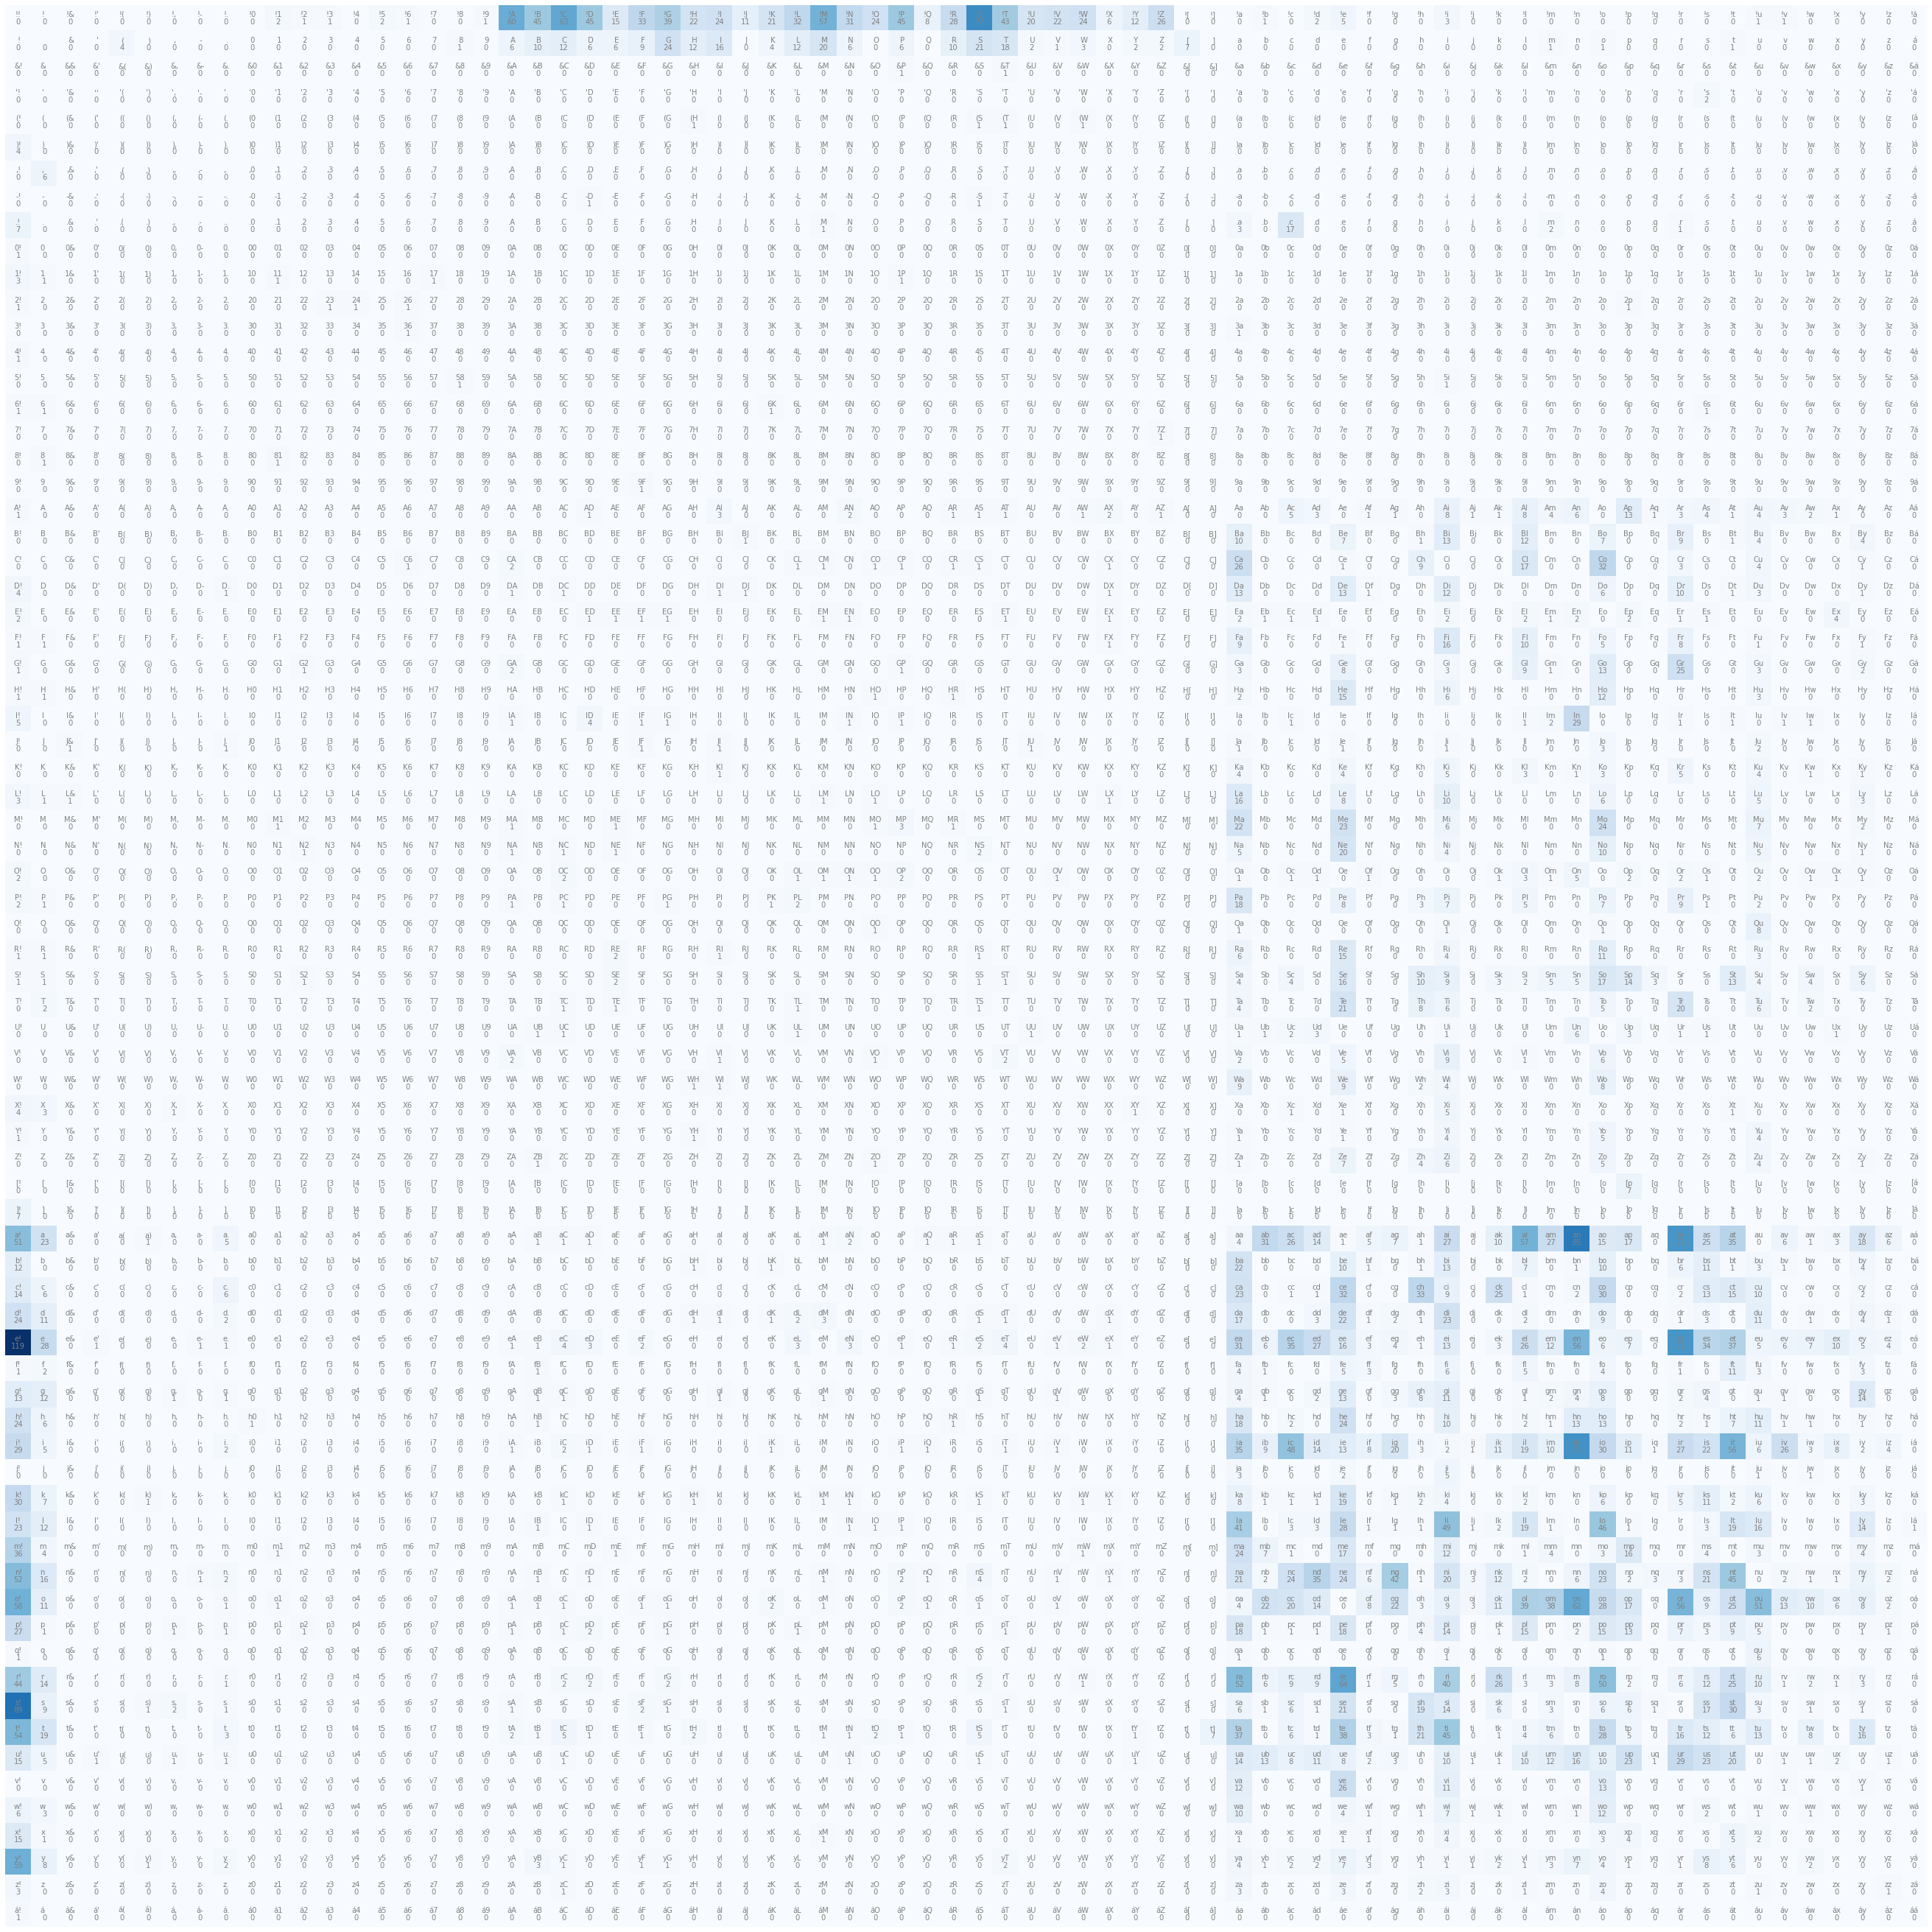

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(48,48))
plt.imshow(N, cmap='Blues')
for i in range(len(stoi)):
  for j in range(len(stoi)):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')

In [15]:
N[0]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  1,  0,  2,  1,  0,  0,
         1, 60, 45, 63, 45, 15, 33, 39, 22, 24, 11, 21, 32, 57, 31, 24, 45,  8,
        28, 77, 43, 20, 22, 24,  6, 12, 26,  0,  0,  0,  1,  0,  2,  5,  0,  0,
         0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,
         0,  0], dtype=torch.int32)

In [16]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0023, 0.0012, 0.0012, 0.0000, 0.0023, 0.0012, 0.0000, 0.0000,
        0.0012, 0.0703, 0.0527, 0.0738, 0.0527, 0.0176, 0.0386, 0.0457, 0.0258,
        0.0281, 0.0129, 0.0246, 0.0375, 0.0667, 0.0363, 0.0281, 0.0527, 0.0094,
        0.0328, 0.0902, 0.0504, 0.0234, 0.0258, 0.0281, 0.0070, 0.0141, 0.0304,
        0.0000, 0.0000, 0.0000, 0.0012, 0.0000, 0.0023, 0.0059, 0.0000, 0.0000,
        0.0000, 0.0035, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0012, 0.0012, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

In [17]:
g = torch.Generator().manual_seed(2147683647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'K'

In [18]:
P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [19]:
g = torch.Generator().manual_seed(2147683647)

for i in range(50):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

Kb!
AAil TroceSIsBiplanh!
Ca9UrrsicIhipzDvazzCa!
Ric IzqCZifNiamhun!
Gin Hol5]S0yBMoua E3)Dedynop1AureNX''a!
Glo!
ng Ten8ClraisaouNjig!
N'YWerl Tre!
Sont!
SQQXDMla STr!
Days!
Norw,Die!
IDHw)JU5Py!
RSpineW[y.!
SoHO BrdAfili!
6wkogs FreDento Gh!
Aprablol!
CHVoi.conditzCoxyeckumyfR1q!
ASerankVágQ1mQQ4xRd]uterksoo5ExJSys!
Aplhyw2E5]!
Z&alouliknag0pGd!
Y]totlaRa,]j-zXIne!
RO0Kras!
Baymas!
3es!
RJ6Pine Ig(fFWJ LechWerbanily.4ecod!
Gomapmp.Wu!
etm!
Wat!
Te!
R9it Uc.anrc0pzp!
Lq'!
Erold6Radantast!
Nrk!
YHoa[3][ctss!
M1 ewNum!
O1WMowetSororpanVe!
Sirg67booCvJ2R'ágl!
Supico CPMx1j9Ycern0HunogpessF6 NUbsofRoururages!
Ram!
lak!
Name!
Q54ee FAwhti]covarpoobalodupitymufc!
HUNDerouth4IncLK831ZeOaw,!
Smaroun!
VchgoRjueCooDYetam!
ANeivesh!
C)y3ZbHS1Paciailolong3WheDXkecab!
Zk)fNoue YgX,.Me!
VixDTrucaiabecPrGocOq'08Sal Fwithenvolend4y!


In [20]:
log_likelihood = 0.0
cnt = 0
for n in names:
# for n in ['Hardik']:
  chs = ['!'] + list(n) + ['!']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    cnt += 1
    # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/cnt}')

log_likelihood=tensor(-24197.8945)
nll=tensor(24197.8945)
2.9309465885162354


In [21]:
xs, ys = [], []

for n in names:
  chs = ['!'] + list(n) + ['!']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [22]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=len(stoi)).float()

In [23]:
xenc.shape

torch.Size([8256, 74])

In [24]:
xenc.dtype

torch.float32

In [25]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((len(stoi), len(stoi)), generator=g)
xenc @ W

tensor([[ 1.5674, -0.2373, -0.0274,  ...,  1.5160, -1.0447, -0.6641],
        [ 0.7896, -0.6847, -0.4240,  ..., -1.9770,  0.8628,  1.4392],
        [ 0.6626,  0.4339, -0.3701,  ..., -0.8869,  1.1494, -0.7259],
        ...,
        [ 1.5321, -1.0163,  0.6591,  ...,  0.6715,  0.0233,  0.0698],
        [ 0.7918,  0.7271,  0.6531,  ..., -0.5777, -1.3386, -0.3019],
        [-0.3349,  1.3562, -0.4406,  ...,  1.6704,  0.3348, -0.7428]])

In [26]:
logits = xenc @ W # log-counts
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[0.0325, 0.0053, 0.0066,  ..., 0.0308, 0.0024, 0.0035],
        [0.0151, 0.0035, 0.0045,  ..., 0.0009, 0.0163, 0.0289],
        [0.0154, 0.0122, 0.0055,  ..., 0.0033, 0.0250, 0.0038],
        ...,
        [0.0320, 0.0025, 0.0134,  ..., 0.0135, 0.0071, 0.0074],
        [0.0195, 0.0183, 0.0170,  ..., 0.0050, 0.0023, 0.0065],
        [0.0057, 0.0307, 0.0051,  ..., 0.0420, 0.0111, 0.0038]])

In [27]:
probs.shape

torch.Size([8256, 74])

In [28]:
probs[0].sum()

tensor(1.0000)

In [29]:
nlls = torch.zeros(len(xs))
for i in range(len(xs))[:1]:
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label index
  p = probs[i, y]
  logp = torch.log(p)
  nll = -logp
  nlls[i] = nll

print('average negative log likelihood, i.e. loss =', nlls.mean().item())

average negative log likelihood, i.e. loss = 0.0006621329230256379


In [30]:
# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((len(stoi), len(stoi)), generator=g, requires_grad=True)

In [31]:
# gradient descrnt
for k in range(100):
  xenc = F.one_hot(xs, num_classes=len(stoi)).float() # input to the network: one-hot encoding
  logits = xenc @ W # predit log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilties for next character
  loss = -probs[torch.arange(len(xs)), ys].log().mean() + 0.01 * (W**2).mean()
  print(loss.item())

  # backward pass
  W.grad = None # set gradient to zero
  loss.backward()

  W.data += -50 * W.grad

4.782886505126953
4.5994110107421875
4.441869735717773
4.303969860076904
4.182790756225586
4.075746059417725
3.980872392654419
3.8968751430511475
3.8227343559265137
3.757431745529175
3.6998634338378906
3.6488709449768066
3.603347063064575
3.562343120574951
3.5251171588897705
3.4911017417907715
3.4598610401153564
3.4310479164123535
3.4043781757354736
3.379613161087036
3.3565526008605957
3.3350253105163574
3.3148860931396484
3.2960095405578613
3.278284788131714
3.261618137359619
3.2459237575531006
3.2311244010925293
3.2171521186828613
3.203944206237793
3.1914429664611816
3.1795966625213623
3.1683568954467773
3.157679319381714
3.147523880004883
3.1378531455993652
3.128632068634033
3.119830369949341
3.1114184856414795
3.103369951248169
3.09566068649292
3.088268280029297
3.081171989440918
3.0743541717529297
3.067796468734741
3.0614826679229736
3.0553994178771973
3.049532413482666
3.043869972229004
3.038400173187256
3.0331130027770996
3.027998685836792
3.023047924041748
3.0182533264160156
3.

In [32]:
# sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=len(stoi)).float()
    logits = xenc @ W
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims=True)

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

Prm!
Avo!
PjeetitoxEOr!
Molir3Gr8FR Relumix!
Tol!
SRVkKice!
ENare HalorilthanagMusLo!
GSLu!
BZamur Inde MolopQFiolo!
Ba!


Source: [The spelled-out intro to language modeling: building makemore | Andrej Karpathy](https://www.youtube.com/watch?v=PaCmpygFfXo)

In [33]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for n in names:
  context = [0] * block_size
  # print(n)
  for ch in n + '!':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [34]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([8256, 3]), torch.int64, torch.Size([8256]), torch.int64)

In [35]:
# build the dataset

def build_dataset(names):
  block_size = 3 # context length: how many characters do we take to predict the next one?
  X, Y = [], []
  for n in names:
    context = [0] * block_size
    # print(n)
    for ch in n + '!':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Ydtr = build_dataset(names[n2:])

torch.Size([6633, 3]) torch.Size([6633])
torch.Size([829, 3]) torch.Size([829])
torch.Size([794, 3]) torch.Size([794])


In [36]:
len(names)

854

In [37]:
n1

683

In [38]:
n2

768

In [39]:
n2 - n1

85

In [40]:
len(names) - n2

86

In [41]:
C = torch.rand((len(stoi), 2))

In [42]:
emb = C[X]
emb.shape

torch.Size([8256, 3, 2])

In [43]:
n_hidden = 100
W1 = torch.randn((6, n_hidden)) * 0.7 # ~= (5 / 3) / ((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden) * 0.01

In [44]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([8256, 6])

In [45]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([8256, 6])

In [46]:
emb.view(8256, 6).shape

torch.Size([8256, 6])

In [47]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([8256, 100])

In [48]:
W2 = torch.randn((n_hidden, len(stoi))) * 0.01
b2 = torch.randn(len(stoi)) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]

In [49]:
sum(p.nelement() for p in parameters) # number of parameters in total

8422

In [50]:
logits = h @ W2 + b2
logits.shape

torch.Size([8256, 74])

In [51]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs.shape

torch.Size([8256, 74])

In [52]:
loss = -probs[torch.arange(8256), Y].log().mean()
loss

tensor(4.3229)

In [53]:
loss = F.cross_entropy(logits, Y)
loss

tensor(4.3229)

In [54]:
for p in parameters:
  p.requires_grad = True

In [55]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre 

In [56]:
lri = []
lossi = []

max_steps = 1000
for i in range(max_steps):
  # minibatch construct
  batch_ix = torch.randint(0, Xtr.shape[0], (32,))
  # forward pass
  emb = C[Xtr[batch_ix]]
  hpreact = emb.view(-1, 6) @ W1 # + b1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 + bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 + bnstdi

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[batch_ix])
  # print(loss.item())
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  # lr = lrs[i]
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  # lri.append(lr)
  if i % 100 == 0:
    print(f'{i:4d}/{max_steps:4d}: {loss.item():.4f}')
  lossi.append(loss.item())

print(loss.item())

   0/1000: 4.2898
 100/1000: 3.6703
 200/1000: 3.3448
 300/1000: 3.2688
 400/1000: 3.3912
 500/1000: 3.0398
 600/1000: 2.7233
 700/1000: 3.2527
 800/1000: 2.7062
 900/1000: 3.0099
3.1623740196228027


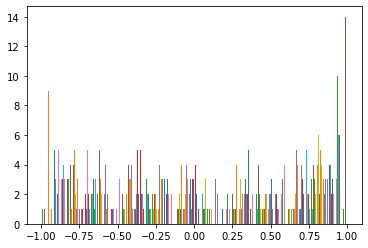

In [57]:
plt.hist(h.tolist(), 50);

In [58]:
emb = C[Xtr]
hpreact = emb.view(-1, 6) @ W1 + b1
hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(4.1367, grad_fn=<NllLossBackward0>)

In [59]:
emb = C[Xdev]
hpreact = emb.view(-1, 6) @ W1 + b1
hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(4.1640, grad_fn=<NllLossBackward0>)

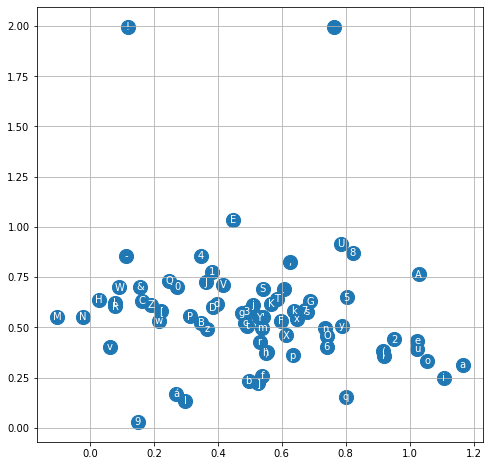

In [60]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [61]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size # initialize all with !!!
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
    
  print(''.join(itos[i] for i in out))

'nTMTWTTcKFSSBGTTLTwWHNC0DFpWDPrW)RCAT[anSMS&X0HACLRDInmSj[SAvIc,T&f!
B5K)5Rn-5GppCpKOápt3Z2ThLH-ZO,PpLCRS0TSSz(gBKWC-0NH[JAZáC&JZC[HOWomG8rh,ATRHUCT9edZXTRn-VpPMapIESACAR26IRLZtNHhDY7CWKcqrS'pgTgIwrgKp'rAp5NBCTTDpZA3PKARPJOS-RyOQT[C'ST9lqDjSmAdTdTIjPSCaxdC7TKNfzBK,JeaneDT&MRT4AUr,DD7'8HeAwd1CLP3RT)IdTrTgTSQRQQp&Tdpp,STTTrTmJ[ujt7XL Y-UFTUYec2pTGGm0WK-GTGeán5IAnenT-UPM6rSicprK8UMK[-AirSTT4'H4GkTEGfncTGWGgpagZG2PcTF(SFTY7SDotFHG8MvAx.-YATTGCR4GSamSEHj'-ffjeU7YwVHK8ZBG[gTYAPTvRDCE9apnd-ITTTIPdB35RKSVJPDPQHTRT1DQrHVAZH78ITCadJAXrTTHSRSSNPH17cN)mVSHKnP13GTDNj&SWLZ9OUTMSVST&sJTiWFK,TRqpgHJHSRT1SSQSGJ0A3tFV0TT4IYHoL9ic-3pn2nppveGTxdWHG[XSdTTBN1TGP!
TCTSnHVTp)gfSOVicSd-pT)O4LaUMhACDSDTkIfciárTeTGH(HVRMCRT)zanTCZe0TDrigSROLEFJMSOHsOC0HALHDHj'DIppavT9vLRXb9VW9aR5TqtT(xrppPSTd1TlYHoLjY-BFHWPTTjMoQpgT3rNHGSCT5CevqingABex&OZKHTWPF.GLLogDCRwH1Z5SWr23TTNtHGdDVTnpfagwVxTAmPK&3T5SffnWTY)U5PSGDSTpzV DStLA)r7'2HX1SMSpn3HGTAfYsT3SCT]xxTT)TTfYLFKGReTdQTDpp KAAgCidD(8hnwLLAMAqvtHCWEQBDTp4QJOpdoDat(mRawThg5

In [69]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
  
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

n_embd = 3 # the dimensionality of the character embedding vectors
n_hidden = 10 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

vocab_size = len(stoi)
# C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

1824


In [70]:
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  x = Xb
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < (max_steps / 2) else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:5d}/{max_steps:5d}: {loss.item(): .4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    0/20000:  4.2955
 1000/20000:  3.4530
 2000/20000:  3.2935
 3000/20000:  3.1124
 4000/20000:  2.8184
 5000/20000:  2.8231
 6000/20000:  3.0952
 7000/20000:  2.9515
 8000/20000:  2.7387
 9000/20000:  2.9871
10000/20000:  2.9404
11000/20000:  2.7092
12000/20000:  2.7802
13000/20000:  2.8771
14000/20000:  2.6757
15000/20000:  3.0284
16000/20000:  3.0146
17000/20000:  2.7663
18000/20000:  2.8357
19000/20000:  2.7746


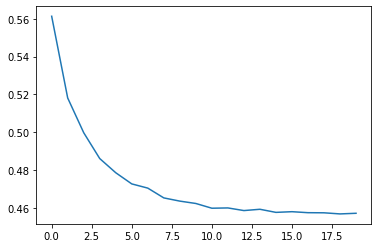

In [64]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

layer 2 (      Tanh): mean -0.05, std 0.69, saturated: 9.38%
layer 5 (      Tanh): mean -0.04, std 0.64, saturated: 8.75%
layer 8 (      Tanh): mean +0.17, std 0.66, saturated: 4.38%
layer 11 (      Tanh): mean +0.05, std 0.70, saturated: 10.31%
layer 14 (      Tanh): mean -0.02, std 0.63, saturated: 4.69%


Text(0.5, 1.0, 'activation distribution')

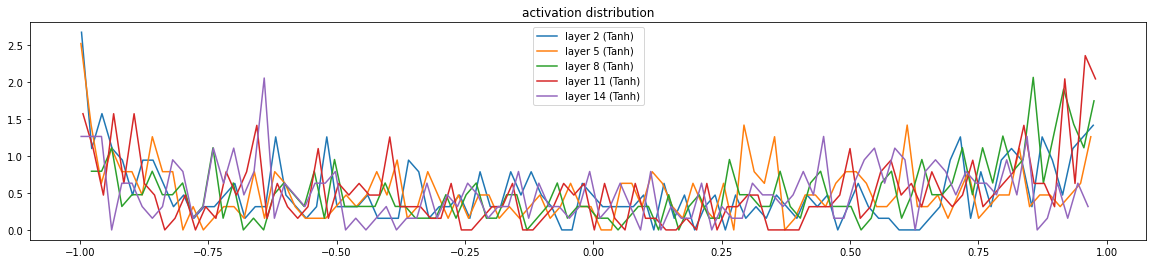

In [65]:
# visualize histograms
plt.figure(figsize=(20,4)) # width and height of the plot
legends =[]
for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.228665e-02
layer 5 (      Tanh): mean -0.000000, std 2.079386e-02
layer 8 (      Tanh): mean +0.000000, std 1.517291e-02
layer 11 (      Tanh): mean +0.000000, std 1.824524e-02
layer 14 (      Tanh): mean -0.000000, std 3.300334e-02


Text(0.5, 1.0, 'gradient distribution')

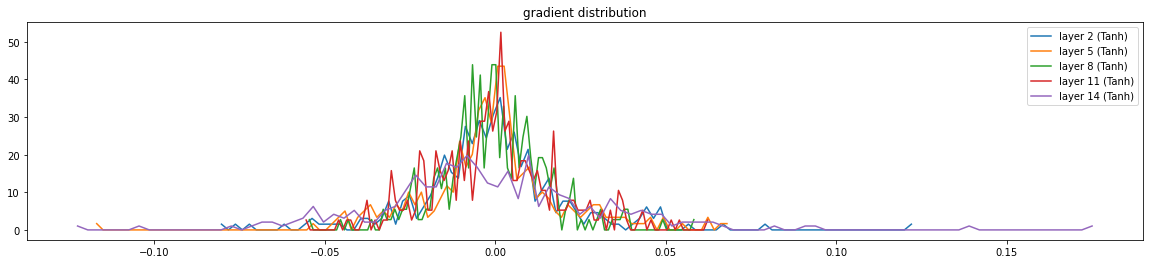

In [66]:
# visualize histograms
plt.figure(figsize=(20,4)) # width and height of the plot
legends =[]
for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')
# Want to check gradients across the layers have roughly equivalent distributions

weight    (74, 3) | mean -0.000000 | std 1.781006e-02 | grad:data ration 1.679546e-02
weight    (9, 10) | mean +0.003962 | std 3.697694e-02 | grad:data ration 6.139576e-02
weight   (10, 10) | mean +0.003578 | std 3.441576e-02 | grad:data ration 5.720112e-02
weight   (10, 10) | mean -0.000885 | std 3.174103e-02 | grad:data ration 5.140575e-02
weight   (10, 10) | mean +0.000218 | std 2.619128e-02 | grad:data ration 4.752655e-02
weight   (10, 10) | mean -0.001279 | std 2.793677e-02 | grad:data ration 4.692038e-02
weight   (10, 74) | mean -0.000193 | std 1.492678e-02 | grad:data ration 2.680396e-02


Text(0.5, 1.0, 'weights gradient distribution')

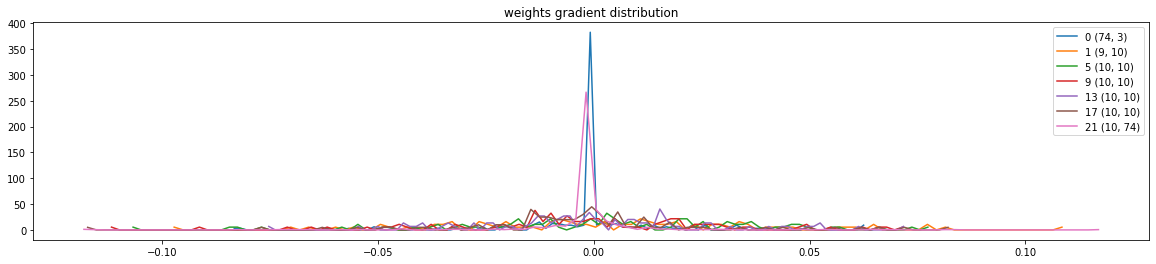

In [67]:
# visualize histograms
plt.figure(figsize=(20,4)) # width and height of the plot
legends =[]
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ration %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

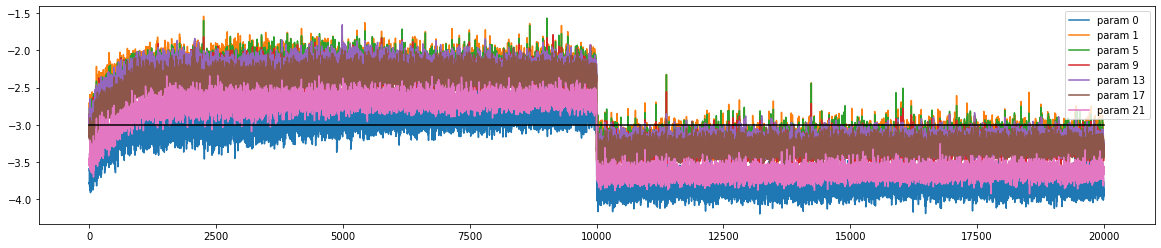

In [68]:
plt.figure(figsize=(20,4)) # width and height of the plot
legends =[]
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append(f'param {i}')
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

Source: [Building makemore Part 2: MLP | Andrej Karpathy](https://www.youtube.com/watch?v=TCH_1BHY58I), [Building makemore Part 3: Activations & Gradients, BatchNorm | Andrej Karpathy](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4), [Building makemore Part 5: Building a WaveNet | Andrek Karpathy](https://www.youtube.com/watch?v=t3YJ5hKiMQ0)